# Search for the order Scleractinia and extract all records below.

In [1]:
import json
from urllib.request import urlopen
import pandas as pd

Searching the order [Scleractinia](https://www.marinespecies.org/aphia.php?p=taxdetails&id=1363) and drill down to all species. 

**AphiaID** 1363  (urn:lsid:marinespecies.org:taxname:1363) 

Collect all the AphiaIDs for the families associated with [Scleractinia](https://www.marinespecies.org/aphia.php?p=taxdetails&id=1363)

The service only provides 50 records, so we need to iterate by 50 until we get less than 50 responses

Need to follow the Taxonomy Classification from order down:
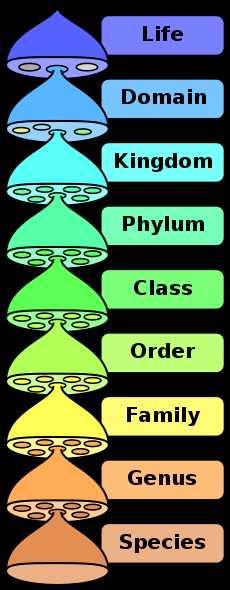

In [2]:
# Use WoRMS REST service
# https://www.marinespecies.org/rest/ and test for one search

# base = 'https://www.marinespecies.org/rest/'

# orderID = '1363'

# family_childs = 'AphiaChildrenByAphiaID/{}'.format(orderID) # get all children

# offset = 1 # Starting recordnumber, when retrieving next chunk of (50) records. Default=1

# worms_url = '{}{}?marine_only=true&offset={}'.format(base,family_childs,offset)

# worms_url



# worms_df = pd.DataFrame()

# for i in range(1,100000,50):
#     offset = i
#     worms_url = '{}{}?marine_only=true&offset={}'.format(base,family_childs,offset)
#     response = urlopen(worms_url)
#     data_json = json.loads(response.read())
#     worms_df = pd.concat([worms_df,pd.DataFrame(data_json)])
#     if len(data_json) < 50:
#         break

        
# worms_df = worms_df[worms_df['rank']=='Family']    # only use family 

# worms_df.shape

Collect all the genuses associated with the family collected above.

In [3]:
# for aphia in worms_df['AphiaID'].unique():
#     for i in range(1,100000,50):
#         offset = i
#         worms_url = '{}{}?marine_only=true&offset={}'.format(base,aphia,offset)
#         try:
#             response = urlopen(worms_url)
#             data_json = json.loads(response.read())
#             worms_df = pd.concat([worms_df,pd.DataFrame(data_json)])
#             if len(data_json) < 50:
#                 break
#         except:
#             continue
# worms_df.shape

Now look for each aphia ID in OBIS and build a mongo data frame.

In [4]:
# base = 'https://api.obis.org/v3/'

# data = pd.DataFrame()

# for aphiaID in worms_df['AphiaID']:

#     occurrence_id = 'occurrence?taxonid={}'.format(aphiaID)
#     url = '{}{}'.format(base,occurrence_id)
#     response= urlopen(url)
#     data_json = json.loads(response.read())
#     data_json['results']
#     data = pd.concat([data, pd.DataFrame(data_json['results'])])
#     #data.head()

# data.describe()

Turns out we can simply search OBIS using the AphiaID for the order Scleractinia and it will return all appropriate records.

Let's replicate this response from OBIS mapper https://mapper.obis.org/?taxonid=1363#

To do:
* figure out years
* figure out species
* figure out taxa

In [2]:
import json
from urllib.request import urlopen
import urllib.parse
import pandas as pd

base = 'https://api.obis.org/v3/'

aphiaID = '1363'
size = 1

# define a polygon
# bound it somehow to between 30 deg N and S latitude
geometry=urllib.parse.quote("POLYGON ((-180 -30, 180 -30, 180 30, -180 30, -180 -30))")

startdepth = 0
enddepth = 30

#occurrence_id = f"occurrence?taxonid={aphiaID}&geometry={geometry}&size={size}"
#.format(aphiaID,geometry,size)
occurrence_id = 'occurrence?taxonid={}&startdepth={}&enddepth={}&geometry={}&size={}'.format(aphiaID,startdepth,enddepth,geometry,size)

url = '{}{}'.format(base,occurrence_id)
response= urlopen(url)
data_json = json.loads(response.read())
size = data_json['total']

print("Found %i records." % size)
print("See in mapper at: %s" % '{}{}#'.format('https://mapper.obis.org/?',occurrence_id.replace("occurrence?","")))


data = pd.DataFrame() # initialize df

# build a list of the subset of fields you want back
# 'occurrenceID','id', 'datasetName','dataset_id','eventDate',
fields = ['id','decimalLatitude','decimalLongitude','species','aphiaID','date_year']

f = "%2C".join([f"{v}" for v in fields])


# The API limits responses to 10,000 entries, so we need to iterate by 10k and use the last occurrence
# uuid to set after "Occurrence UUID up to which to skip."
for i in range(10000,size,10000):
    if i == 10000:
        # build url for first call
        occurrence_id = 'occurrence?taxonid={}&startdepth={}&enddepth={}&geometry={}&fields={}&size=10000'.format(aphiaID,startdepth,enddepth,geometry,f)
    else:
        # build url for remaining calls
        uuid = data.iloc[-1]['id']
        occurrence_id = 'occurrence?taxonid={}&startdepth={}&enddepth={}&geometry={}&fields={}&after={}&size=10000'.format(aphiaID,startdepth,enddepth,geometry,f,uuid)
        
    url = '{}{}'.format(base,occurrence_id)
    # open the api call
    response= urlopen(url) 
    # read in the json
    data_json = json.loads(response.read())
    # build a mongo dataframe with all results
    data = pd.concat([data, pd.DataFrame(data_json['results'])])
    
    print(len(data_json['results']),data.shape)
    
    # kick out of loop at the end
    if len(data_json['results']) < 10000:
        break

# Need to grab from last iteration to expected size.
uuid = data.iloc[-1]['id']
occurrence_id = 'occurrence?taxonid={}&startdepth={}&enddepth={}&geometry={}&fields={}&after={}&size=10000'.format(aphiaID,startdepth,enddepth,geometry,f,uuid)
url = '{}{}'.format(base,occurrence_id)
response= urlopen(url)
data_json = json.loads(response.read())
data_json['results']
data = pd.concat([data, pd.DataFrame(data_json['results'])])
print(len(data_json['results']),data.shape)        

data.shape

Found 348982 records.
See in mapper at: https://mapper.obis.org/?taxonid=1363&startdepth=0&enddepth=30&geometry=POLYGON%20%28%28-180%20-30%2C%20180%20-30%2C%20180%2030%2C%20-180%2030%2C%20-180%20-30%29%29&size=1#
10000 (10000, 6)
10000 (20000, 6)
10000 (30000, 6)
10000 (40000, 6)
10000 (50000, 6)
10000 (60000, 6)
10000 (70000, 6)
10000 (80000, 6)
10000 (90000, 6)
10000 (100000, 6)
10000 (110000, 6)
10000 (120000, 6)
10000 (130000, 6)
10000 (140000, 6)
10000 (150000, 6)
10000 (160000, 6)
10000 (170000, 6)
10000 (180000, 6)
10000 (190000, 6)
10000 (200000, 6)
10000 (210000, 6)
10000 (220000, 6)
10000 (230000, 6)
10000 (240000, 6)
10000 (250000, 6)
10000 (260000, 6)
10000 (270000, 6)
10000 (280000, 6)
10000 (290000, 6)
10000 (300000, 6)
10000 (310000, 6)
10000 (320000, 6)
10000 (330000, 6)
10000 (340000, 6)
8982 (348982, 6)


(348982, 6)

In [3]:
print("records:",data.shape[0])
print("Years: %i - %i" % (data["date_year"].astype(float).min(),data["date_year"].astype(float).max()))
print("Species:", len(data['species'].dropna().unique()))
print("Taxa:", len(data['aphiaID'].dropna().unique()))

records: 348982
Years: 1874 - 2021
Species: 823
Taxa: 951


In [45]:
## Just pulling the coordinates
# base = 'https://api.obis.org/v3/'

# aphiaID = '1363'

# occurrence_points = 'occurrence/points?taxonid={}&startdepth={}&enddepth={}&geometry={}'.format(aphiaID,startdepth,enddepth,geometry)
# url = '{}{}'.format(base,occurrence_points)
# response= urlopen(url)
# data_json = json.loads(response.read())
# data = pd.DataFrame(data_json['coordinates'])
# data.shape

Make the histogram of occurrences

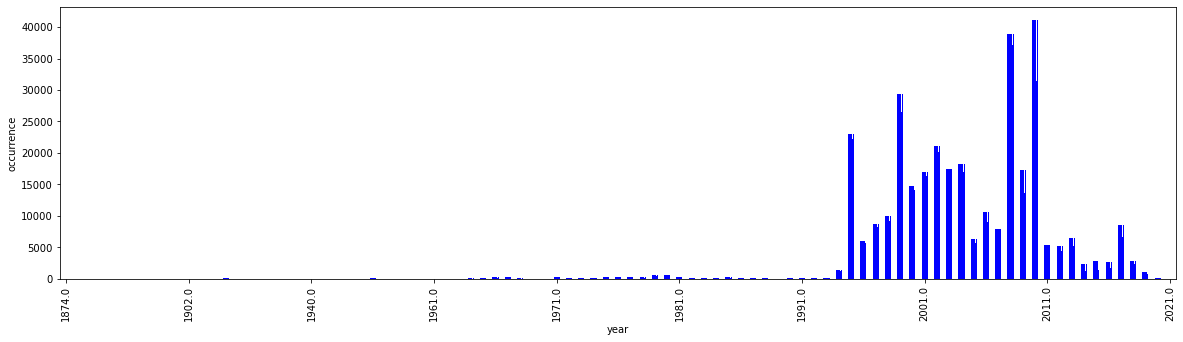

In [4]:
import matplotlib as plt

data['date'] = pd.to_datetime(data['date_year'],format="%Y")

year_group = data.groupby(data['date'].dt.year)

ax = year_group.count().plot(kind="bar", 
                             color='blue',
                             legend=False, 
                             figsize=(20, 5),
                             ylabel='occurrence',
                             xlabel='year',
                            )

ax.xaxis.set_major_locator(plt.ticker.MaxNLocator(10))

What is our maximum occurrence count in one year?

In [5]:
year_group['date_year'].count().max()

41153

This jives with the OBIS mapper!

Now create a gridded geodataframe. Using the example at https://james-brennan.github.io/posts/fast_gridding_geopandas/

In [8]:
import geopandas as gpd

gdf = gpd.GeoDataFrame(
    data, geometry=gpd.points_from_xy(data.decimalLongitude, data.decimalLatitude),
    crs="EPSG:4326")

Now bin the GeoDataFrame to 180 x 180 cells.

In [9]:
import numpy as np
import shapely

# total area for the grid
xmin, ymin, xmax, ymax= [-180., -90., 180., 90]
# how many cells across and down
n_cells=180
cell_size = (xmax-xmin)/n_cells
# projection of the grid
#crs = "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs"
# create the cells in a loop
grid_cells = []
for x0 in np.arange(xmin, xmax+cell_size, cell_size ):
    for y0 in np.arange(ymin, ymax+cell_size, cell_size):
        # bounds
        x1 = x0-cell_size
        y1 = y0+cell_size
        grid_cells.append( shapely.geometry.box(x0, y0, x1, y1)  )
        
cell = gpd.GeoDataFrame(grid_cells, columns=['geometry'], 
                                 crs="EPSG:4326")
    
# ax = gdf.plot(markersize=.1, figsize=(12, 8),)# column='dob', cmap='jet')
# plt.autoscale(False)
# cell.plot(ax=ax, facecolor="none", edgecolor='grey')
# ax.axis("off")

merged = gpd.sjoin(gdf, cell, how='left', op='within')

# make a simple count variable that we can sum
merged['n_occur'] = 1
# Compute stats per grid cell -- aggregate fires to grid cells with dissolve
dissolve = merged.dissolve(by="index_right", aggfunc="count")
# put this into cell
cell.loc[dissolve.index, 'n_occur'] = dissolve.n_occur.values

C:\Users\Mathew.Biddle\programs\Anaconda3\envs\sandbox\lib\site-packages\IPython\core\interactiveshell.py:3377: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


Make map using geopandas plot

(-18505373.647955876, 18641494.8163134, -9473562.580980353, 9191411.568387408)

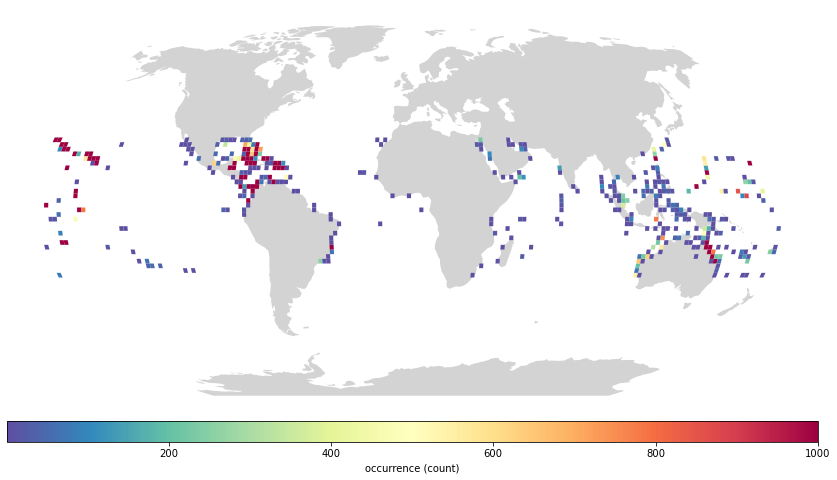

In [10]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pycrs

crs = pycrs.parse.from_esri_code(54030)
#crs.geogcs.prime_mer.value = 160.0
crs_str = crs.to_proj4()

fig, ax = plt.subplots(figsize=(16,8), facecolor='white')
#ax = plt.subplot(1, 4, 4, figsize=(16,8))

#fig = plt.figure(figsize=(16, 8))

#mol = ccrs.Mollweide()
#ax = fig.add_subplot(1, 1, 1,)

# start map with entire world
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.dissolve()

world.to_crs(crs_str).plot( ax=ax,
                            color='lightgrey', 
                            edgecolor=None,
                            linewidth=None
                            )

divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.1)

# plot the gridded occurrence cells
cell.to_crs(crs_str).plot( ax=ax,
                           column='n_occur', 
                           cmap='Spectral_r', 
                           vmin=1, 
                           vmax=1000, 
                           edgecolor=None, 
                           legend=True,
                           legend_kwds={'label': "occurrence (count)",
                                        'orientation': "horizontal"},
                           cax=cax,
                           )

plt.autoscale(False)

#ax.outline_patch.set_visible(True)
#world.to_crs("ESRI:54009").plot(ax=ax, color='none', edgecolor='black',linewidth=.5)
ax.axis('off')
#plt.grid(True)

Make a map using geoplot (easier and more customizable)

C:\Users\Mathew.Biddle\programs\Anaconda3\envs\sandbox\lib\site-packages\geoplot\geoplot.py:623: UserWarning: Cannot set "figsize" when passing an "ax" to the plot. To remove this warning omit the "figsize" parameter.
  warnings.warn(
C:\Users\MATHEW~1.BID\AppData\Local\Temp\3/ipykernel_16028/1334243384.py:44: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.set_global(); ax.outline_patch.set_visible(True)
C:\Users\Mathew.Biddle\programs\Anaconda3\envs\sandbox\lib\site-packages\cartopy\crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\Mathew.Biddle\programs\Anaconda3\envs\sandbox\lib\site-packages\cartopy\crs.py:239: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecate

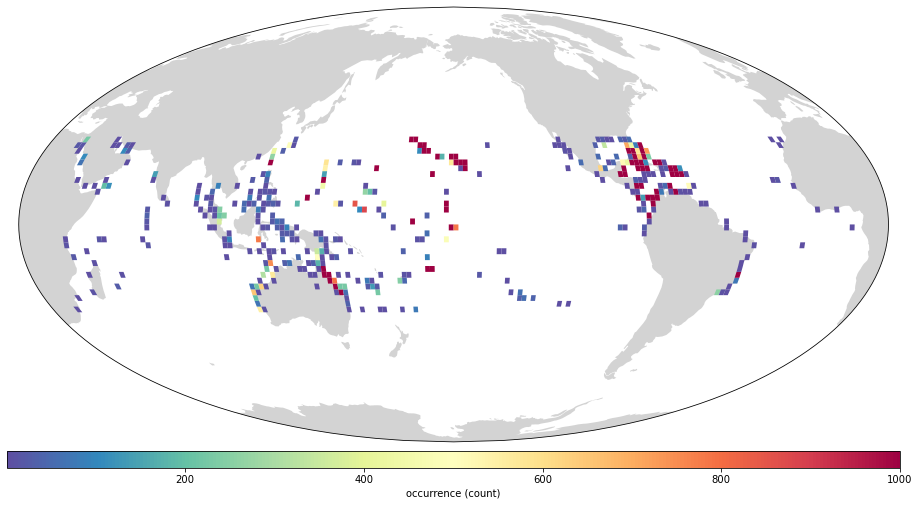

In [19]:
import geoplot
import geoplot.crs as gcrs
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

norm = mpl.colors.Normalize(vmin=1, vmax=1000)

#projection = gcrs.Robinson(central_longitude=-160)
projection=gcrs.Mollweide(central_longitude=-160)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.dissolve()

fig, ax = plt.subplots(figsize=(16,8), facecolor=None, subplot_kw={'projection':projection})

geoplot.polyplot(
    world,
    figsize=(16,8),
    facecolor='lightgray',
    edgecolor=None,
    projection=projection,
    ax=ax,
)

cax = fig.add_axes([0.125, 0.08, 0.775, 0.03])

cell = cell[~cell['n_occur'].isna()] # drop all NaN cells - makes plotting quicker.

geoplot.choropleth(cell, 
                   hue='n_occur', 
                   edgecolor=None, 
                   projection=projection, 
                   ax=ax,
                   cmap='Spectral_r',
                   legend=True,
                   legend_kwargs={'orientation': 'horizontal',
                                  'cax':cax,
                                  'label':"occurrence (count)",
                                 },
                   norm=norm, 
                  )

ax.set_global(); ax.outline_patch.set_visible(True)

Now let's look at some statistics on the number of occurrences per cell:

In [43]:
cell['n_occur'].describe()

count      410.000000
mean       849.848780
std       2928.457962
min          1.000000
25%          3.000000
50%         19.000000
75%        241.500000
max      37829.000000
Name: n_occur, dtype: float64

Make a latitudinal histogram

array([[<AxesSubplot:title={'center':'decimalLatitude'}>]], dtype=object)

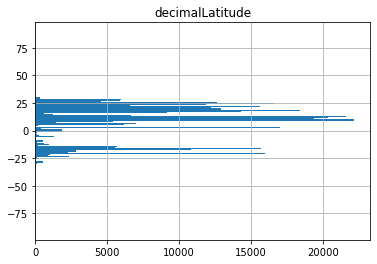

In [42]:
bins = [i for i in range(-90, 90, 1)]

data.hist(column='decimalLatitude', bins=bins, orientation='horizontal')

Combine the latitude histogram with the map to recreate this figure https://bbest.github.io/obis-lat-time-fig/#map,_hist,_time-series_combined

To do: link histogram y axis with map latitude lines.

C:\Users\Mathew.Biddle\programs\Anaconda3\envs\sandbox\lib\site-packages\geoplot\geoplot.py:623: UserWarning: Cannot set "figsize" when passing an "ax" to the plot. To remove this warning omit the "figsize" parameter.
  warnings.warn(
C:\Users\MATHEW~1.BID\AppData\Local\Temp\3/ipykernel_16028/1670271005.py:48: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.set_global(); ax.outline_patch.set_visible(True);
C:\Users\MATHEW~1.BID\AppData\Local\Temp\3/ipykernel_16028/1670271005.py:62: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  count, lat = pd.np.histogram(data['decimalLatitude'], bins=bins)


Text(0.5, 1.0, '')

C:\Users\Mathew.Biddle\programs\Anaconda3\envs\sandbox\lib\site-packages\cartopy\crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\Mathew.Biddle\programs\Anaconda3\envs\sandbox\lib\site-packages\cartopy\crs.py:239: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
C:\Users\Mathew.Biddle\programs\Anaconda3\envs\sandbox\lib\site-packages\cartopy\crs.py:239: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(

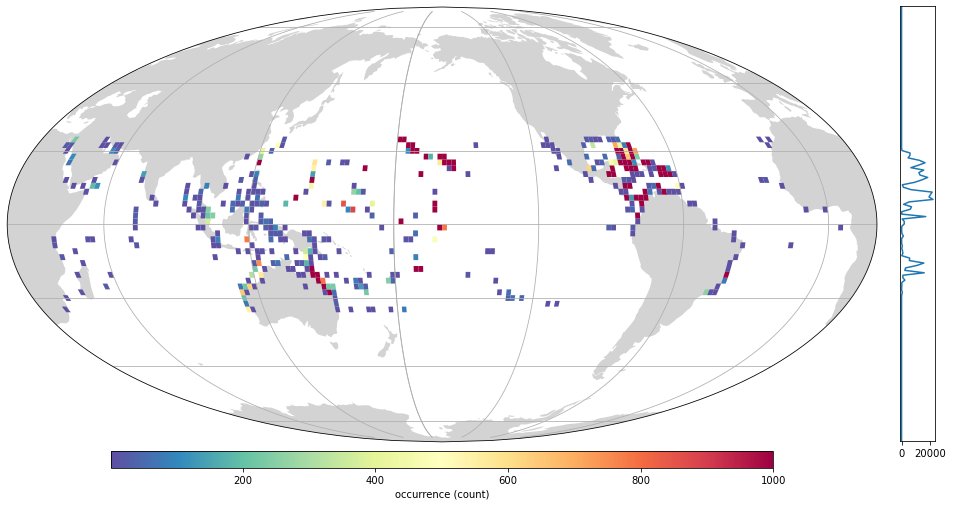

In [38]:
import geoplot
import geoplot.crs as gcrs
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

norm = mpl.colors.Normalize(vmin=1, vmax=1000)

projection=gcrs.Mollweide(central_longitude=-160)

#projection=gcrs.Robinson(central_longitude=-160)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.dissolve()

fig, ax = plt.subplots(figsize=(16,8), facecolor='white', subplot_kw={'projection':projection})

geoplot.polyplot(
    world,
    figsize=(16,8),
    facecolor='lightgray',
    edgecolor=None,
    projection=projection,
    ax=ax,
)


cax = fig.add_axes([0.225, 0.08, 0.575, 0.03])


# drop na cells
cell = cell[~cell['n_occur'].isna()]

geoplot.choropleth(cell, 
                   hue='n_occur', 
                   edgecolor=None, 
                   projection=projection, 
                   ax=ax,
                   cmap='Spectral_r',
                   legend=True,
                   legend_kwargs={'orientation': 'horizontal',
                                  'cax':cax,
                                  'label':"occurrence (count)",
                                 },
                   norm=norm, 
                  )

ax.set_global(); ax.outline_patch.set_visible(True); 

import matplotlib.ticker as mticker

gl = ax.gridlines()
gl.ylocator = mticker.FixedLocator([-90, -75, -50, -25, 0, 25, 50, 75, 90])

# [0.91, 0.125, 0.03, 0.7555]

ax2 = fig.add_axes([0.91, 0.1257, 0.03, 0.7555])

bins = [i for i in range(-90, 90, 1)]


count, lat = pd.np.histogram(data['decimalLatitude'], bins=bins)

ynums = np.linspace(ax.yaxis.get_data_interval()[0],ax.yaxis.get_data_interval()[1],179)

ax2.plot(count,ynums)
ax2.sharey(ax)
ax2.axes.get_yaxis().set_visible(False)

#data.hist(column='decimalLatitude', bins=bins, orientation='horizontal', ax=ax2, )
plt.title('')